In [1]:
import pandas as pd 
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

/Users/emrekuru/Developer/Fine-Tune/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("financial_phrasebank", "sentences_50agree", trust_remote_code=True)

df = pd.DataFrame(dataset['train'])

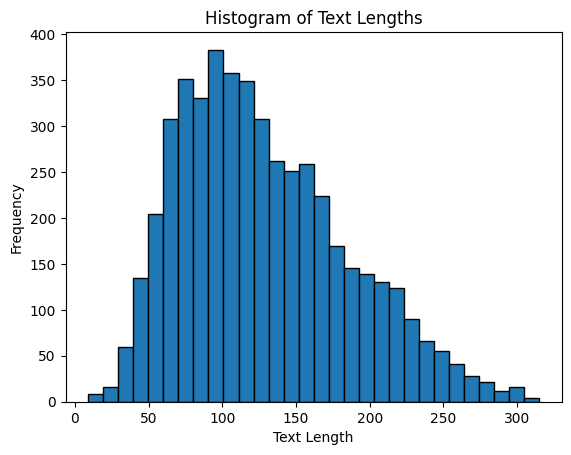

In [3]:
df['text_length'] = df['sentence'].apply(len)
plt.hist(df['text_length'], bins=30, edgecolor='black')
plt.title('Histogram of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Stratify split into train, validation, and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['sentence'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, stratify=train_labels, random_state=42
)

train_df = pd.DataFrame({'sentence': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'sentence': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'sentence': test_texts, 'label': test_labels})

In [5]:
test_df

,sentence,label
2108,"Following the payment made in April , the comp...",1
4276,The share subscription period for C options wi...,1
478,Aspocomp intends to set up a plant to manufact...,1
810,Finnish Rautaruukki has been awarded a contrac...,2
4648,Finnish Bank of +àland reports its operating p...,0
...,...,...
1567,Nokia will continue to invest in future develo...,2
997,Uponor improved its performance in spite of th...,2
307,Total operating revenue grew by 27.6 % year-on...,2
518,The equipment will expand container handling c...,2


In [6]:
models = {
    "DistilBERT" : np.zeros(len(test_df)),
    "BERT Base" :  np.zeros(len(test_df)),
    "LoRA BERT" :  np.zeros(len(test_df)),
    "T5 Large" :  np.zeros(len(test_df)),
    "LLAMA 2" :  np.zeros(len(test_df)),
    "GPT 3.5" : pd.read_csv('predictions/gpt-3.5.csv')['prediction'],
    "GPT 4" :  pd.read_csv('predictions/gpt-4.csv')['prediction'],
}

## Evaluate

In [7]:
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
results_df = pd.DataFrame(columns=metrics, index=models.keys())
results_df

,Accuracy,F1 Score,Precision,Recall
DistilBERT,NaN,NaN,NaN,NaN
BERT Base,NaN,NaN,NaN,NaN
LoRA BERT,NaN,NaN,NaN,NaN
T5 Large,NaN,NaN,NaN,NaN
LLAMA 2,NaN,NaN,NaN,NaN
GPT 3.5,NaN,NaN,NaN,NaN
GPT 4,NaN,NaN,NaN,NaN


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_metrics(metrics_df, metrics_to_plot):
    # Generate distinct colors for each model
    colors = list(mcolors.TABLEAU_COLORS.values())  # Use Tableau color palette
    model_colors = colors[:len(metrics_df.index)]  # Match the number of models

    n_metrics = len(metrics_to_plot)
    n_cols = 2  # Number of subplots per row
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Calculate the number of rows needed

    plt.figure(figsize=(16, n_rows * 4))  # Adjust size based on the number of metrics and columns
    
    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Extract data for the current metric
        data_to_plot = metrics_df[metric]
        
        # Plot bar graph with distinct colors for each model
        plt.bar(metrics_df.index, data_to_plot, color=model_colors, edgecolor='black', width=0.6)  # Adjust width for spacing
        
        # Add labels and title
        plt.title(f"{metric.capitalize()} Comparison", fontweight='bold', fontsize=14)
        plt.xlabel("Model", fontweight='bold', fontsize=14)
        plt.ylabel(metric.capitalize(), fontweight='bold', fontsize=14)
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=0.4)  # Increase space between plots
    plt.show()

In [9]:
def evaluate_predictions(y_test, predictions):

    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "F1 Score": f1_score(y_test, predictions, average="weighted", zero_division=0),
        "Precision": precision_score(y_test, predictions, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, predictions, average="weighted", zero_division=0),
    }
    
    return metrics

In [10]:
for model in models.keys():
    predictions = models[model]
    metrics = evaluate_predictions(test_df['label'], predictions)
    results_df.loc[model] = metrics

results_df

,Accuracy,F1 Score,Precision,Recall
DistilBERT,0.124742,0.02767,0.015561,0.124742
BERT Base,0.124742,0.02767,0.015561,0.124742
LoRA BERT,0.124742,0.02767,0.015561,0.124742
T5 Large,0.124742,0.02767,0.015561,0.124742
LLAMA 2,0.124742,0.02767,0.015561,0.124742
GPT 3.5,0.693814,0.699329,0.768728,0.693814
GPT 4,0.827835,0.824299,0.826397,0.827835


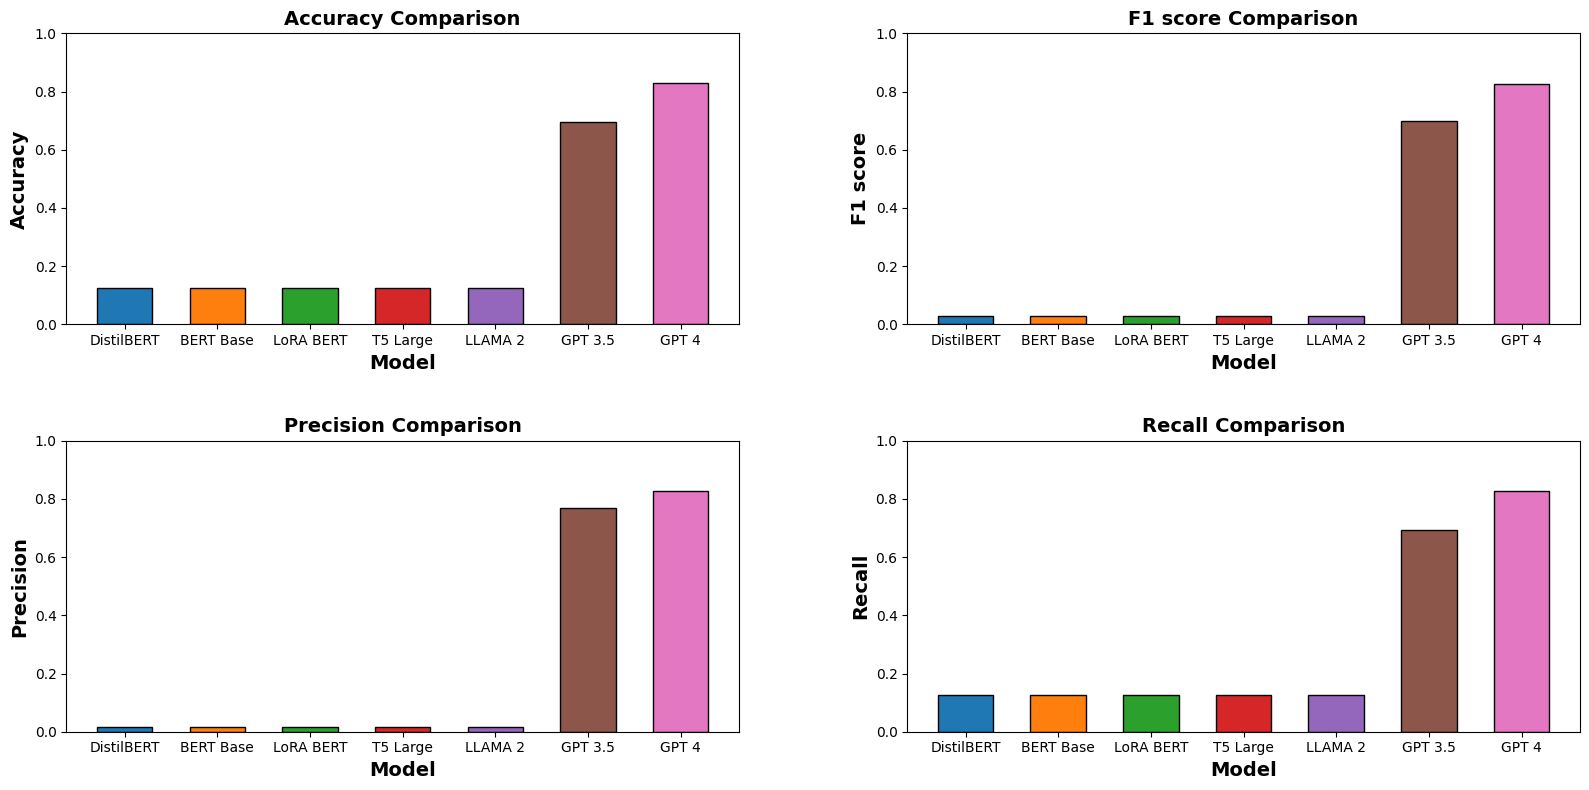

In [11]:
plot_metrics(metrics_df=results_df, metrics_to_plot=metrics)